In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision as tv

# from model import config

#Check whether we use a GPU or a CPU
if torch.cuda.is_available():
  print("We are using GPU")
  device = torch.device("cuda")
else:
  print("We are using CPU")
  device = torch.device("cpu")

We are using CPU


We load the image and we prepare it as an input to our network.
To do so we choose to resize it to 224x224 and normalize the pixels using the values extracted from the paper `"Deep Residual Learning for Image Recognition" by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun (2016)`


In [2]:
def image_loader(path):
    image = Image.open(path)
    preprocessor = tv.transforms.Compose([
        tv.transforms.Resize(size=(224, 224)),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocessor(image)
    #Adding the batchsize dimension : (batch_size, channels, height, width)
    image = torch.unsqueeze(image, dim=0)
    return image

In [3]:
#Loading images and moving them to CPU or GPU
content_image = image_loader('tesla.jpeg').to(device)
style_image = image_loader('van_gogh.jpg').to(device)

In [4]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def tensor_to_image(tensor):
    """ Display a tensor as an image. """
    tensor = tensor.to("cpu").clone() #Moving the tensor to cpu
    image = tensor.detach().numpy().squeeze() #freeze params and remove the dimension 0 and 
    image = image.transpose(1,2,0) #transpose (H,W,C)
    #Removing normalization
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

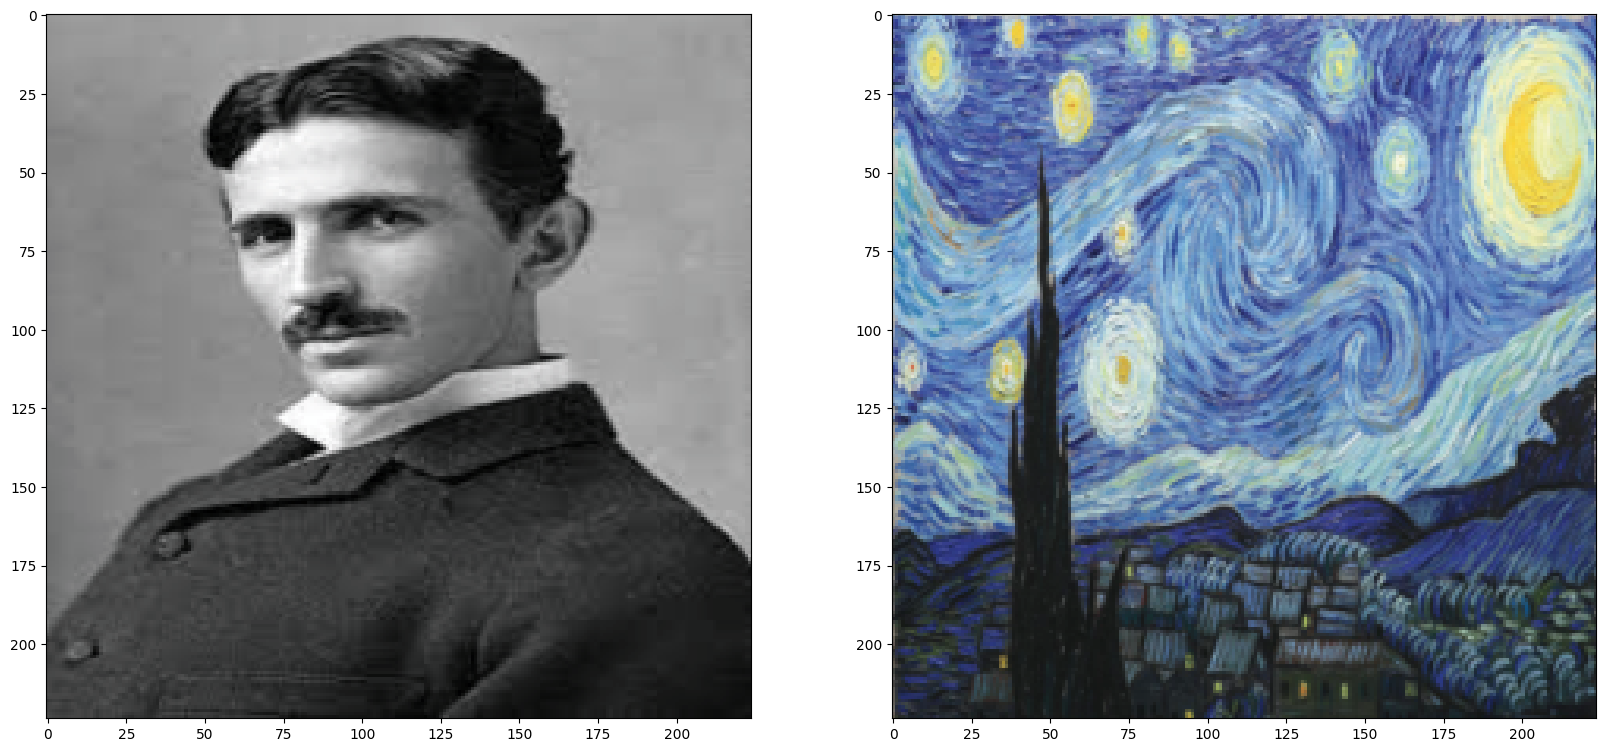

In [5]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(tensor_to_image(content_image))
ax2.imshow(tensor_to_image(style_image))
plt.show()


In [27]:
diy_model = torch.load(confi.BEST_MODEL_PATH).features
#the model is pre trained for classification, we freeze the parameters
for parameter in diy_model.parameters():
    parameter.requires_grad_(False)

diy_model.to(device)

ModuleNotFoundError: ignored

In [6]:
vgg = tv.models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 50.9MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
def gram_matrix(tensor):    
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [8]:
def get_features(image, model, layers_names):
    features = []
    curr_output = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        curr_output = layer(curr_output)
        if name in layers_names:
            features.append(curr_output)
    return features


In [9]:
for name, module in diy_model.named_children():
    print(f"Name: {name}, module: {module}")

NameError: ignored

In [ ]:
content_layers_diy = ['16']
style_layers_diy = ['0', '4', '8', '12', '16']

In [10]:
for name, module in vgg.named_children():
    print(f"Name: {name}, module: {module}")

Name: 0, module: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 1, module: ReLU(inplace=True)
Name: 2, module: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 3, module: ReLU(inplace=True)
Name: 4, module: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Name: 5, module: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 6, module: ReLU(inplace=True)
Name: 7, module: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 8, module: ReLU(inplace=True)
Name: 9, module: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Name: 10, module: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 11, module: ReLU(inplace=True)
Name: 12, module: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 13, module: ReLU(inplace=True)
Name: 14, module: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 

In [11]:
content_layers_vgg = ['34']
style_layers_vgg = ['2', '7', '16', '25', '34']

In [ ]:
content_features = get_features(content_image, diy_model, content_layers_diy)
style_features = get_features(style_image, diy_model, style_layers_diy)
style_features = [gram_matrix(feature) for feature in style_features]


1
torch.Size([128, 128])


In [12]:
content_features_vgg = get_features(content_image, vgg, content_layers_vgg)
style_features_vgg = get_features(style_image, vgg, style_layers_vgg)
style_features_vgg = [gram_matrix(feature) for feature in style_features_vgg]

In [13]:
content_weight = 1  
style_weight = 1 

In [18]:
target_image = content_image.clone().requires_grad_(True).to(device)
opt = optim.Adam([target_image], lr=0.003)

In [19]:
def nst_step(target_image, model, content_layers, style_layers, content_features, style_features):
    #Minimizing content loss 
    content_targets = get_features(target_image, model, content_layers)
    content_loss = 0
    for i in range(len(content_layers)):
        content_loss += torch.mean((content_features[i] - content_targets[i])**2)
    #Minimizing style loss
    style_targets = get_features(target_image, model, style_layers)
    style_targets = [gram_matrix(target) for target in style_targets]
    style_loss = 0
    for i in range(len(style_layers)):
        style_loss += torch.mean((style_features[i] - style_targets[i])**2)
    loss = content_weight * content_loss + style_weight * style_loss
    #Updating target_image
    opt.zero_grad() #resetting gradients because pytorch accumulates them
    loss.backward()
    opt.step()

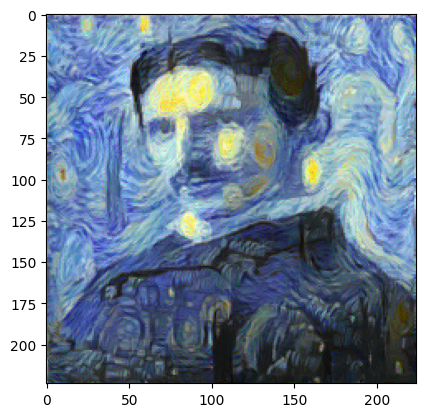

In [20]:
#VGG
epochs = 20
steps_per_epoch = 1000
for _ in range(epochs):
    for _ in range(steps_per_epoch):
        nst_step(target_image, vgg, content_layers_vgg, 
                 style_layers_vgg, content_features_vgg, style_features_vgg)

plt.imshow(tensor_to_image(target_image))
plt.show()

In [3]:
plt.imshow(tensor_to_image(target_image))
plt.show()

NameError: name 'tensor_to_image' is not defined

In [ ]:
plt.imshow(tensor_to_image(target_image))

In [16]:
#DIY Model
epochs = 20
steps_per_epoch = 1000
for _ in range(epochs):
    for _ in range(steps_per_epoch):
        nst_step(target_image, diy_model, content_layers_diy, 
                 style_layers_diy, content_features, style_features)

plt.imshow(tensor_to_image(target_image))
plt.show()

NameError: ignored